# Inteligencja Obliczeniowa w Analizie danych cyfrowych

## Lab 3. Gymnasium - Wykorzystanie reinforcement learning do rozwiązania gier dyskretnych i ciągłych 

### Miłosz Góralczyk

Jak ostatnio, umieściłem część raportu nad częścią kodu, w celu lepszego dostępu dla sprawdzającego. 

Aby wygenerować ponownie dane, również te wykorzystane w Raporcie, należy najpierw uruchomić komórki częśći II. Kod źródłowy laboratorium

Zrealizowałem zadania 1 i 2, na 8 punktów

## I. Raport z laboratorium

FrozenLake-v1 - Discrete space

Gra zoptymalizowana w ramach pierwszej części ćwiczenia to Frozen Lake z modułu Toy-Text

Celem gry jest nawigowanie po planszach jeziora, tak aby za pomocą komend up, down, left, right, dostać się od pola startu do pola mety

Standardowo są to narożniki kwadratowej planszy.

Każde z pól może być lodem lub dziurą. Zadaniem Programu jest przejście po lodzie nie wpadająć do żadnej z dziur.

Dodatkowo gra posiada argument is_slippery. Jeżeli ustawiony na 'True', gracz po wykonaniu ruchu będzie poruszać się po lodzie aż do napotkania przeszkody

Wybrana przeze mnie wersja środowiska posiada 16 kratek, w kwadracie 4x4

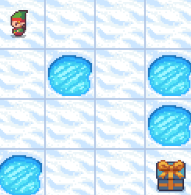

### Model i Ćwiczenie

Uczenie zostało przeprowadzone wykorzystuąc jako podstawę wzykłą sieć Q Network, posiadającą 32 nody na dwóch wewnętrznych warstwach

- warstwa wejściowa (2 wartości, x i y gracza)
- pierwsza warstwa ukryta (32 nody)
- druga warstwa ukryta (32 nody)
- wyjście akcji (1 wartość, kierunek ruchu)

Discount Factor został ustawiony na 0.9

Learning rate na 0.02

Liczba epochów na których przetrenowano model wynosi 10000


### Podsumowanie

W przypadku nauczania sieci na grze dyskretnej, istnieje skończona ilość możliwych ruchów, oraz nie ma niepewności fizycznych.

Wobec tego, stosując odpowiednio długie uczenie, można dla mniejszych problemów rozwiązać grę bez większych przeszkód.

W ramach 10.000 epochów, udało się utrzymać przeciętny score przy wartości 1.0

To oznacza, że za każdym razem programowi udało się osiągnąć cel dotarcia do mety bez wpadnięcia do jeziora.

Wartość is_slippery nie zmienia znacząco działania programu, lecz często prowadzi do rozwiązania w mniejszej liczbie ruchów, co upraszcza proces nauczania.

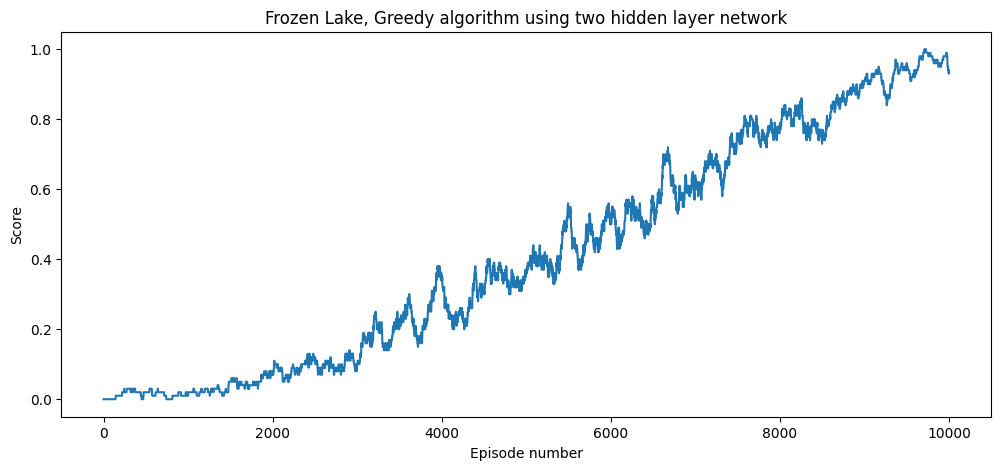

### Wyniki

Zwykły algorytm typu greedy, priorytyzujący jak najwyższy wynik w jak najmniejszym czasie, zoptymalizował w czasie około 6 minut grę Frozen Lake o wielkości 16 kratek

W tym dyskretnym przypadku, daje się otrzymać wynik wyuczonego modelu 1.0. To oznacza że program nauczył się poprawnie rozwiązywać problem za każdym razem

### Wnioski

W tym ćwiczeniu, udało się wykazać możlowość rozwiązania problemów dyskretnych całkowicie

Górna granica wyniku programu gwarantuje sukces za każdym razem

Zróżnicowanie parametrów generacji jak is_slippery nie wpływa w zauważalny sposób na zmianę procesu nauczania.

Przeprowadziłem początkowo eksperyment na planszy 8x8, jednak w tym przypadku nauczanie trwało zbyt długo i nie udało mi się z odpowiednim czasie doprowadzić do rozwiązania problemu.

Wraz z wielkością planszy, ilość obliczeń przeprowadzonych przez model w celu rozwiązania wzrasta o rzędy wielkości.

## Inverted Pendulum-v4 - continous space

gra zoptymalizowana w ramach drugiej części ćwiczenia jest Inverted-Pendulum-v4 z grupy „Multi-Joint dynamics with Contact”, w skrócie MuJoCo

Zadaniem modelu jest nauczenie się tak aplikować siłę, by utrzymać wahadło na górze wagonika. Celem i nagrodą jest czas utrzymania końca wahadła na maksymalnej wysokości 

hiperparametry ustawione do uczenia modelu to pięć seedów, z których każdy uczy się przez 3000 epok.

Learing Rate wynosi 5e-4, a epsilon Variation Instability to 1e-7

Trzy wartości gamma sprawdzone pod kątem współczynników dyskontowych to 0,9, 0,7 i 0,5


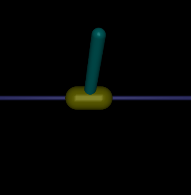

### Model i Ćwiczenie

Uczenie zostało przeprowadzone wykorzystuąc jako podstawę Q-Network, złożoną z:

- warstwa wejściowa 
- Sieć dzielona - warstwy 16 i 32 neuronowe, z Złamaniem liniowości funkcją Tanh
- Sieć wyjścia - akcje 
- Sieć wyjścia - niepewności

Łącznie zostało przeprowadzone 22500 epochów nauczania, z przetestowaniem wielu wartości Discount Factor

## Podsumowanie

Współczynnik gamma odpowiadający za discount factor, wpływa na to, jak bardzo model podczas uczenia preferuje zmaksymalizować możliwie wynik current reward, traktując go jako prawdopodobieństwo że dany epoch nauczania jest ostatnim.

Z gamma = 1.0 zawsze będzie działał jak typowy model próbujący uzyskać najlepszy możliwy wynik.

Poniżej tego, może wchodzić na ustępstwa, aby w następnych iteracjach być w lepszej pozycji.

Można go uprościć do pojęcia odłożonej w czasie nagrody.


## Wyniki

Przetrenowane modele sprawdzone były dla wartości DF 0.9, 0.7, oraz 0.5.

chociaż z wyniku końcowego nie można bezpośrednio zauważyć związku z poprawą ostatecznej nagrody z powodu zbyt małych ilości danych,

to umiarkowana wartość, gamma = 0.7 uzyskała najwyższy wynik, czyli była najbliżej celu.

Największą różnicę widać na wykresach nauczania modeli w czasie, im mniejsza wartość tym mniej nagłych gwałtownych spadków na wykresie mogących znacząco popsuć wyniki,

ale i gorsza poprawa wyniku między epochami.


## Wnioski

Współczynnik Discount Factor można uznać za padding modelu, ktry ogranicza ryzyko znaczącej zmiany negatywnej między epochami wynikającej z wprowadzeniu losowego szumu epsilon

Ogranicza on też wydajność modelu, ale w umiarkowanym zastosowaniu, działa jak filtr medianowy dla nauczania ze wzmocnieniem

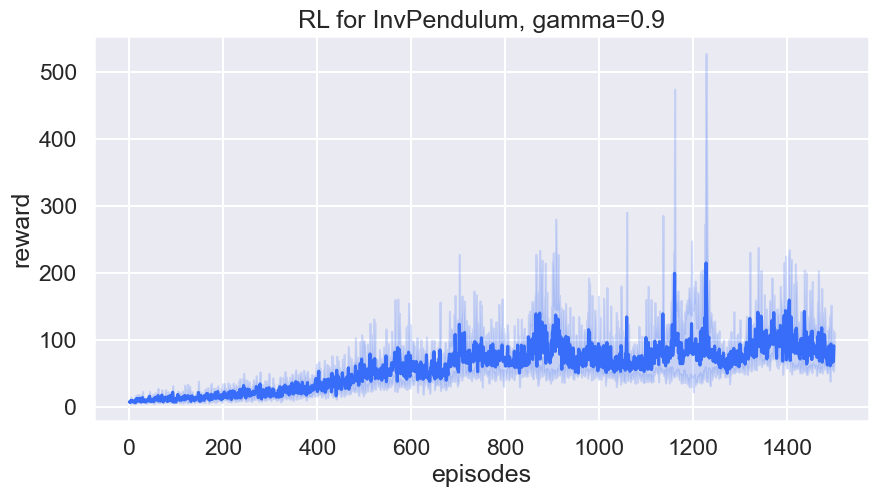
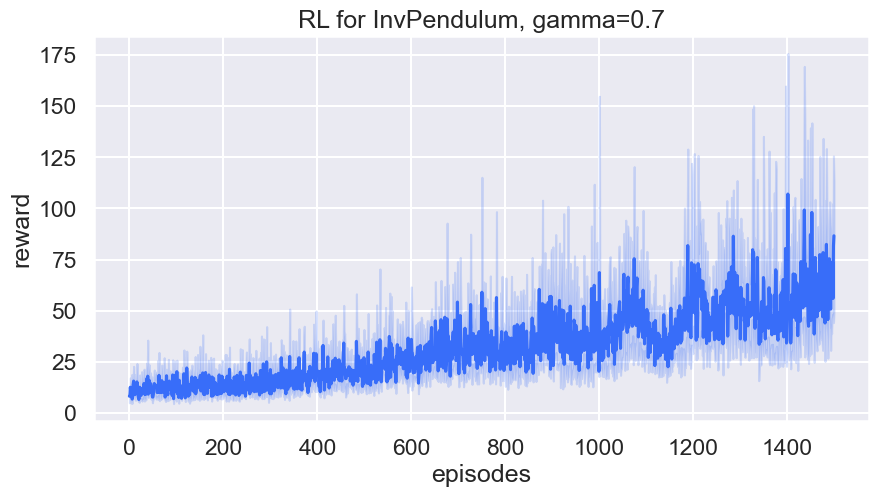
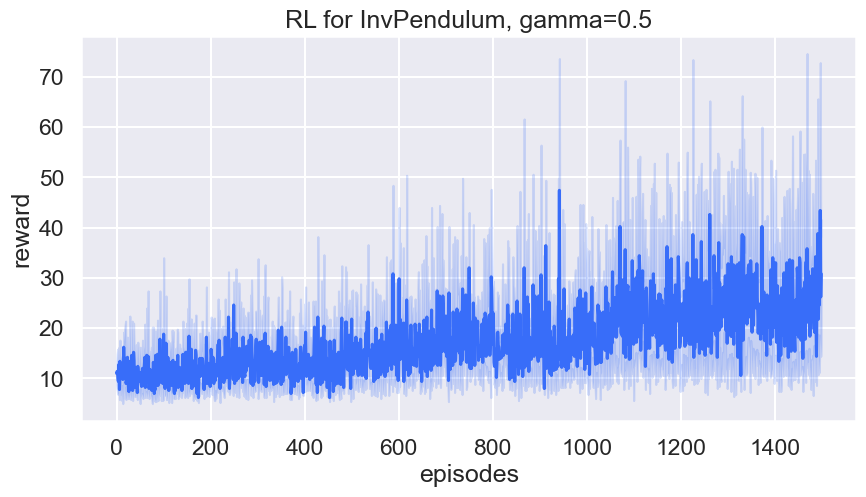

## II. Kod źródłowy laboratorium, pozyskanie danych

## Część 1 - Discrete Space, Frozen Lake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Final
from gymnasium import make
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import torch
from torch.nn import Module, Linear, MSELoss
from torch.nn.functional import relu
import torch.optim as optim
from torch import FloatTensor

DISCOUNT_FACTOR = 0.9
RANDOM_STATE = 100
EPISODES = 10_000

### Setup środowiska podstawowego

In [2]:
env = make("FrozenLake-v1", desc=generate_random_map(4, 0.8, RANDOM_STATE), is_slippery=False)

num_states: int = env.observation_space.n
num_actions: int = env.action_space.n

In [6]:
print(f"Number of states: {num_states}")
print(f"Number of actions: {num_actions}")

Number of states: 16
Number of actions: 4


In [4]:
from collections import deque
from random import sample, random


class DeepQNetwork(Module):
    def __init__(self, in_states: int = 16, h1_nodes: int = 32, out_actions: int = 4) -> None:
        super().__init__()

        self.layer1: Linear = Linear(in_states, h1_nodes)
        self.layer2: Linear = Linear(h1_nodes, h1_nodes)
        self.output_layer: Linear = Linear(h1_nodes, out_actions)

    def forward(self, x):
        return self.output_layer(
            relu(
                self.layer2(
                    relu(
                        self.layer1(x)
                    )
                )
            )
        )
    
def to_tensor(state) -> torch.Tensor:
  tensor = torch.zeros(num_states)
  tensor[state] = 1.
  return tensor
class Memory:
    def __init__(self, max_len: int) -> None:
        self.memory: deque = deque([], maxlen=max_len)

    def append(self, transition) -> None:
        self.memory.append(transition)

    def sample(self, sample_size: int):
        return sample(self.memory, sample_size)

    def __len__(self) -> int:
        return len(self.memory)
    
    
memory = Memory(1000)
policy = DeepQNetwork(num_states, 32, num_actions)
target = DeepQNetwork(num_states, 32, num_actions)

target.load_state_dict(policy.state_dict())

optimizer = optim.Adam(policy.parameters(), lr=0.02)

rewards_per_episode = np.zeros(EPISODES)

epsilon: float = 1.
step_count: int = 0

In [5]:
for i in range(EPISODES):
    state = env.reset()[0]

    while True:
        if random() < epsilon:
            action = env.action_space.sample()
        else:          
            with torch.no_grad():
                action = policy(to_tensor(state)).argmax().item()

        new_state, reward, terminated, truncated, _ = env.step(action)
        memory.append((state, action, new_state, reward, terminated))

        state = new_state

        step_count += 1
        
        if terminated or truncated:
            break

    if reward == 1:
        rewards_per_episode[i] = 1.

    if len(memory) > 64 and np.sum(rewards_per_episode) > 0:
        mini_batch = memory.sample(64)

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target_tensor = FloatTensor([reward])
            else:
                with torch.inference_mode():
                    target_tensor = FloatTensor(
                        reward + DISCOUNT_FACTOR * target(to_tensor(new_state)).max()
                    )

            current_q = policy(to_tensor(state))
            current_q_list.append(current_q)

            target_q = target(to_tensor(state))
            target_q[action] = target_tensor
            target_q_list.append(target_q)

        loss = MSELoss()(torch.stack(current_q_list), torch.stack(target_q_list))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epsilon = max(epsilon - 1 / EPISODES, 0)

        if step_count > 10:
            target.load_state_dict(policy.state_dict())
            step_count = 0

        if i % 100 == 0:
            print(f"Episode {i} - Loss: {loss}")

Episode 200 - Loss: 0.0003135066945105791
Episode 300 - Loss: 0.00040185946272686124
Episode 400 - Loss: 5.002157195121981e-05
Episode 500 - Loss: 0.00011480161629151553
Episode 600 - Loss: 2.558258302087779e-06
Episode 700 - Loss: 6.747313108235176e-08
Episode 800 - Loss: 7.054210726664678e-08
Episode 900 - Loss: 5.521607135960949e-07
Episode 1000 - Loss: 1.5033859881441458e-06
Episode 1100 - Loss: 0.00025760955759324133
Episode 1200 - Loss: 6.224721437320113e-05
Episode 1300 - Loss: 7.932136941235512e-05
Episode 1400 - Loss: 8.926360351324547e-06
Episode 1500 - Loss: 1.3884136023989413e-05
Episode 1600 - Loss: 7.551229828095529e-06
Episode 1700 - Loss: 2.0785728338523768e-05
Episode 1800 - Loss: 8.251360850408673e-05
Episode 1900 - Loss: 2.6522229745751247e-06
Episode 2000 - Loss: 4.152413566771429e-06
Episode 2100 - Loss: 6.599384505534545e-05
Episode 2200 - Loss: 0.00011033408372895792
Episode 2300 - Loss: 2.269722244818695e-05
Episode 2400 - Loss: 4.702856676885858e-05
Episode 250

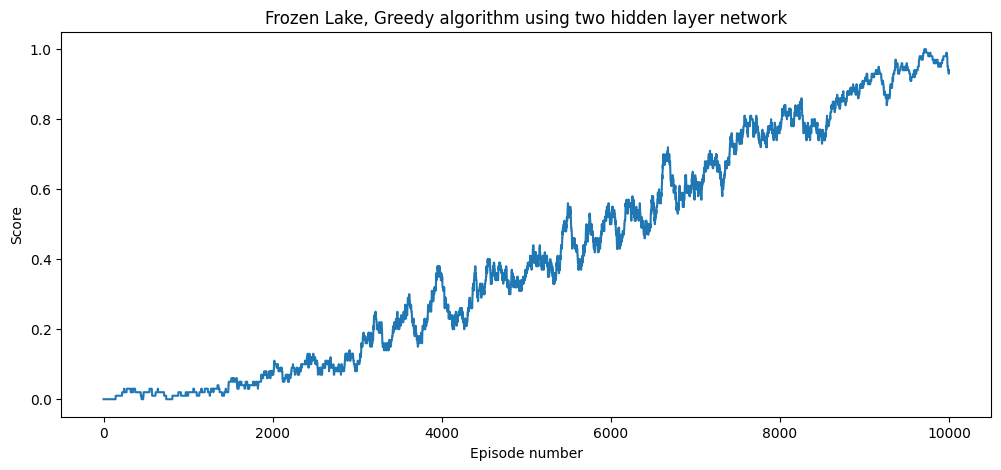

In [7]:
plt.figure(1, figsize=(12, 5))
plt.title("Frozen Lake, Greedy algorithm using two hidden layer network")
plt.xlabel("Episode number")
plt.ylabel("Score")

sum_rewards = np.zeros(EPISODES)
for x in range(EPISODES):
    sum_rewards[x] = np.sum(rewards_per_episode[max(0, x - 100): (x + 1)] / 100)
plt.subplot(111)
plt.plot(sum_rewards)
plt.show()

In [23]:
env = make("FrozenLake-v1", desc=generate_random_map(4, 0.8, RANDOM_STATE), is_slippery=True)

In [24]:
for i in range(EPISODES):
    state = env.reset()[0]

    while True:
        if random() < epsilon:
            action = env.action_space.sample()
        else:          
            with torch.no_grad():
                action = policy(to_tensor(state)).argmax().item()

        new_state, reward, terminated, truncated, _ = env.step(action)
        memory.append((state, action, new_state, reward, terminated))

        state = new_state

        step_count += 1
        
        if terminated or truncated:
            break

    if reward == 1:
        rewards_per_episode[i] = 1.

    if len(memory) > 64 and np.sum(rewards_per_episode) > 0:
        mini_batch = memory.sample(64)

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target_tensor = FloatTensor([reward])
            else:
                with torch.inference_mode():
                    target_tensor = FloatTensor(
                        reward + DISCOUNT_FACTOR * target(to_tensor(new_state)).max()
                    )

            current_q = policy(to_tensor(state))
            current_q_list.append(current_q)

            target_q = target(to_tensor(state))
            target_q[action] = target_tensor
            target_q_list.append(target_q)

        loss = MSELoss()(torch.stack(current_q_list), torch.stack(target_q_list))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epsilon = max(epsilon - 1 / EPISODES, 0)

        if step_count > 10:
            target.load_state_dict(policy.state_dict())
            step_count = 0

        if i % 100 == 0:
            print(f"Episode {i} - reward: {reward}")

Episode 0 - reward: 0.0
Episode 100 - reward: 0.0
Episode 200 - reward: 0.0
Episode 300 - reward: 0.0
Episode 400 - reward: 0.0
Episode 500 - reward: 0.0
Episode 600 - reward: 0.0
Episode 700 - reward: 0.0
Episode 800 - reward: 0.0
Episode 900 - reward: 0.0
Episode 1000 - reward: 0.0
Episode 1100 - reward: 0.0
Episode 1200 - reward: 0.0
Episode 1300 - reward: 0.0
Episode 1400 - reward: 0.0
Episode 1500 - reward: 0.0
Episode 1600 - reward: 0.0
Episode 1700 - reward: 0.0
Episode 1800 - reward: 0.0
Episode 1900 - reward: 0.0
Episode 2000 - reward: 0.0
Episode 2100 - reward: 0.0
Episode 2200 - reward: 0.0
Episode 2300 - reward: 0.0
Episode 2400 - reward: 0.0
Episode 2500 - reward: 0.0
Episode 2600 - reward: 0.0
Episode 2700 - reward: 0.0
Episode 2800 - reward: 0.0
Episode 2900 - reward: 0.0
Episode 3000 - reward: 0.0
Episode 3100 - reward: 0.0
Episode 3200 - reward: 0.0
Episode 3300 - reward: 0.0
Episode 3400 - reward: 0.0
Episode 3500 - reward: 0.0
Episode 3600 - reward: 0.0
Episode 3700 

## Część 2 - Continous Space, Inverted Pendulum

In [26]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

plt.rcParams["figure.figsize"] = (10, 5)

In [27]:
import gymnasium as gym
env = gym.make('InvertedPendulum-v4')

In [28]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()

        hidden_space1 = 16  
        hidden_space2 = 32  

        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [33]:
class REINFORCE_gamma_0_9:

    def __init__(self, obs_space_dims: int, action_space_dims: int):


        self.learning_rate = 0.0005  # Learning rate for policy optimization
        self.gamma = 0.9  # Discount factor
        self.eps = 0.0000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        running_g = 0
        gs = []

        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.probs = []
        self.rewards = []

class REINFORCE_gamma_0_7:

    def __init__(self, obs_space_dims: int, action_space_dims: int):

        # Hyperparameters
        self.learning_rate = 0.0005  # Learning rate for policy optimization
        self.gamma = 0.7  # Discount factor
        self.eps = 0.000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)


        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        running_g = 0
        gs = []

        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.probs = []
        self.rewards = []

class REINFORCE_gamma_0_5:

    def __init__(self, obs_space_dims: int, action_space_dims: int):

        # Hyperparameters
        self.learning_rate = 0.0005  # Learning rate for policy optimization
        self.gamma = 0.5  # Discount factor
        self.eps = 0.000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        running_g = 0
        gs = []

        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.probs = []
        self.rewards = []

In [34]:
# Create and wrap the environment
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(1500)
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
rewards_over_seeds_1 = []
rewards_over_seeds_2 = []
rewards_over_seeds_3 = []

for seed in [46, 50, 61, 21, 37]:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    agent_1 = REINFORCE_gamma_0_9(obs_space_dims, action_space_dims)
    reward_over_episodes_1 = []

    agent_2 = REINFORCE_gamma_0_7(obs_space_dims, action_space_dims)
    reward_over_episodes_2 = []

    agent_3 = REINFORCE_gamma_0_5(obs_space_dims, action_space_dims)
    reward_over_episodes_3 = []

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_1.sample_action(obs)

            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_1.rewards.append(reward)

            done = terminated or truncated

        reward_over_episodes_1.append(wrapped_env.return_queue[-1])
        agent_1.update()

        if episode % 100 == 0 or episode == total_num_episodes - 1:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Seed:",seed, " Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_1.append(reward_over_episodes_1)

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_2.sample_action(obs)

            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_2.rewards.append(reward)

            done = terminated or truncated

        reward_over_episodes_2.append(wrapped_env.return_queue[-1])
        agent_2.update()

        if episode % 100 == 0 or episode == total_num_episodes - 1:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Seed:",seed, " Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_2.append(reward_over_episodes_2)

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_3.sample_action(obs)

            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_3.rewards.append(reward)

            done = terminated or truncated

        reward_over_episodes_3.append(wrapped_env.return_queue[-1])
        agent_3.update()

        if episode % 100 == 0 or episode == total_num_episodes - 1:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Seed:",seed, " Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_3.append(reward_over_episodes_3)

print("Training complete.")



Seed: 46  Episode: 0 Average Reward: 9
Seed: 46  Episode: 100 Average Reward: 11
Seed: 46  Episode: 200 Average Reward: 16
Seed: 46  Episode: 300 Average Reward: 24
Seed: 46  Episode: 400 Average Reward: 34
Seed: 46  Episode: 500 Average Reward: 28
Seed: 46  Episode: 600 Average Reward: 50
Seed: 46  Episode: 700 Average Reward: 48
Seed: 46  Episode: 800 Average Reward: 53
Seed: 46  Episode: 900 Average Reward: 37
Seed: 46  Episode: 1000 Average Reward: 71
Seed: 46  Episode: 1100 Average Reward: 38
Seed: 46  Episode: 1200 Average Reward: 47
Seed: 46  Episode: 1300 Average Reward: 84
Seed: 46  Episode: 1400 Average Reward: 120
Seed: 46  Episode: 1499 Average Reward: 127
Seed: 46  Episode: 0 Average Reward: 125
Seed: 46  Episode: 100 Average Reward: 9
Seed: 46  Episode: 200 Average Reward: 11
Seed: 46  Episode: 300 Average Reward: 14
Seed: 46  Episode: 400 Average Reward: 18
Seed: 46  Episode: 500 Average Reward: 19
Seed: 46  Episode: 600 Average Reward: 25
Seed: 46  Episode: 700 Average 

### plot the data for every gamma value

In [35]:
import pandas as pd
import seaborn as sns

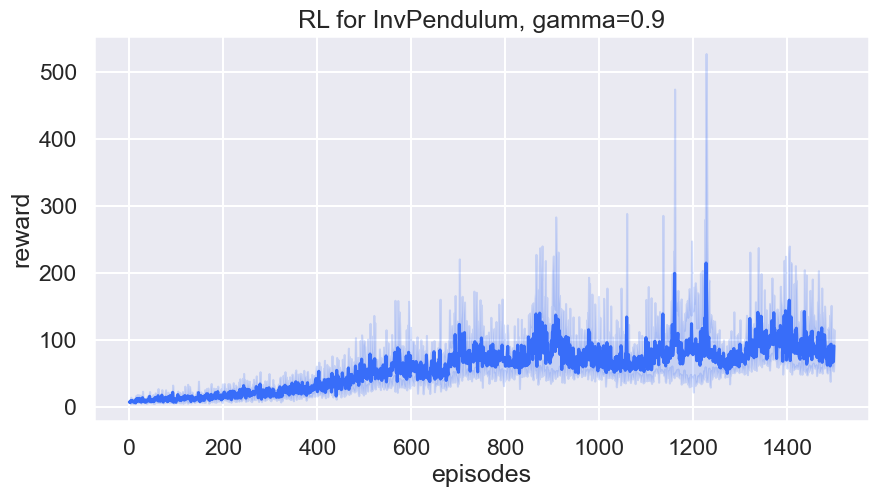

In [39]:
rewards_to_plot_1 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_1]
df1 = pd.DataFrame(rewards_to_plot_1).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="RL for InvPendulum, gamma=0.9"
)
plt.show()

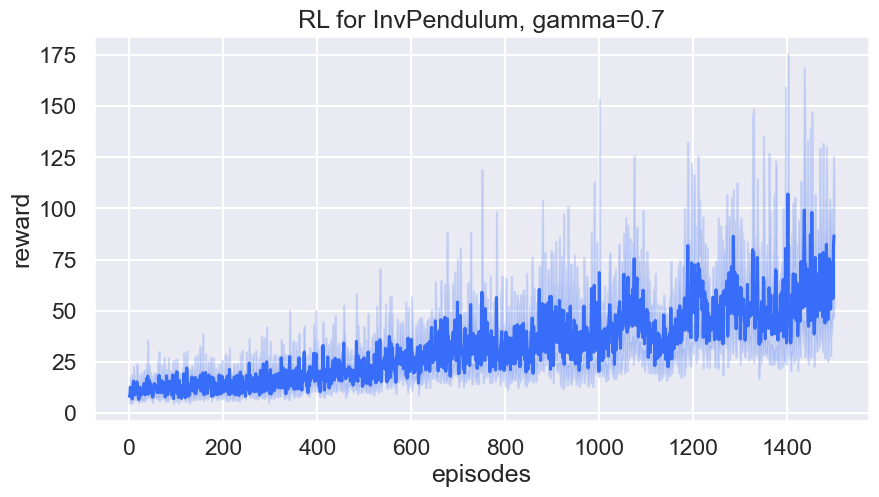

In [38]:
rewards_to_plot_2 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_2]
df2 = pd.DataFrame(rewards_to_plot_2).melt()
df2.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df2).set(
    title="RL for InvPendulum, gamma=0.7"
)
plt.show()

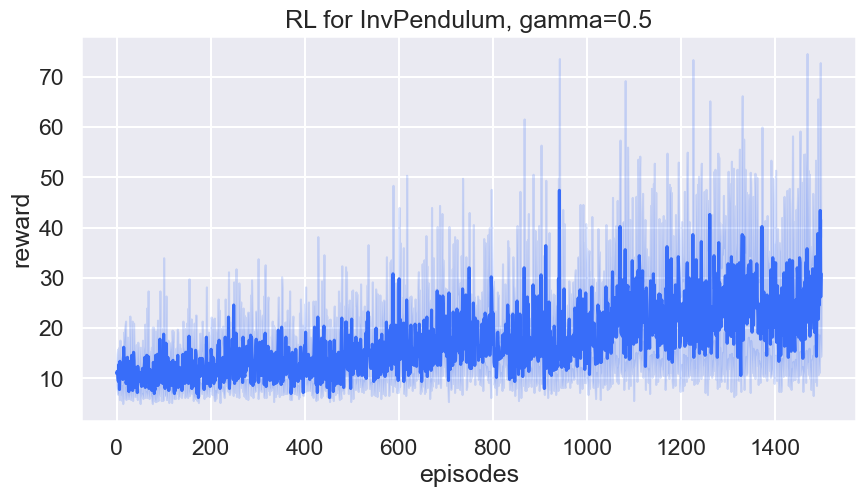

In [40]:
reward_to_plot_3 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_3]
df3 = pd.DataFrame(reward_to_plot_3).melt()
df3.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df3).set(
    title="RL for InvPendulum, gamma=0.5"
)
plt.show()


In [41]:

final_rewards_1 = [rewards[-1] for rewards in rewards_over_seeds_1]
final_rewards_2 = [rewards[-1] for rewards in rewards_over_seeds_2]
final_rewards_3 = [rewards[-1] for rewards in rewards_over_seeds_3]

avg_final_reward_1 = np.mean(final_rewards_1)
avg_final_reward_2 = np.mean(final_rewards_2)
avg_final_reward_3 = np.mean(final_rewards_3)

print("Average final reward for gamma=0.9: ", avg_final_reward_1)
print("Average final reward for gamma=0.7: ", avg_final_reward_2)
print("Average final reward for gamma=0.5: ", avg_final_reward_3)



Average final reward for gamma=0.9:  90.8
Average final reward for gamma=0.7:  86.6
Average final reward for gamma=0.5:  30.8


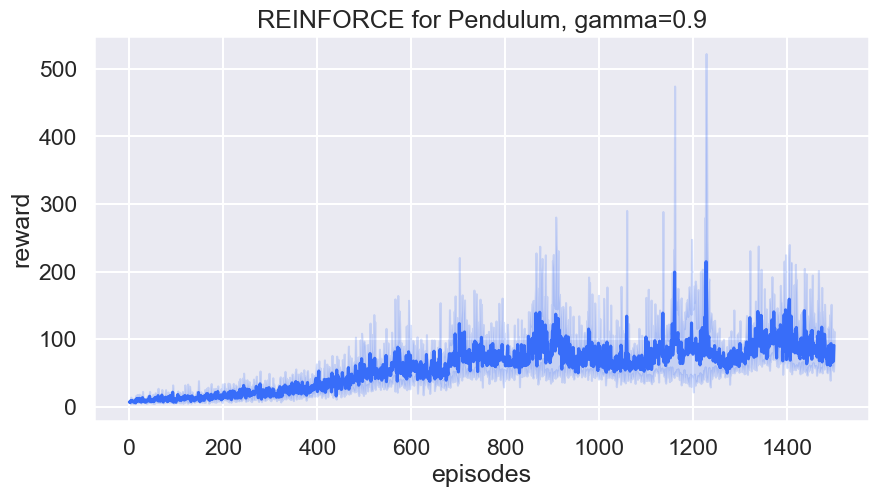

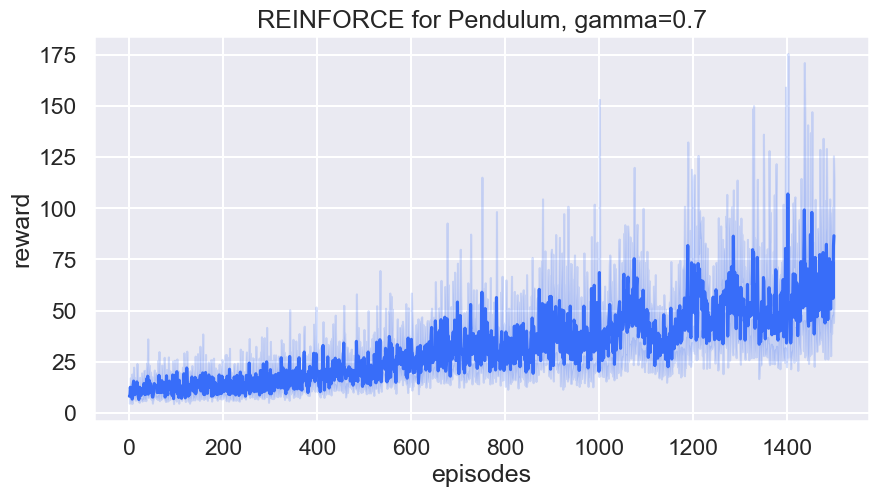

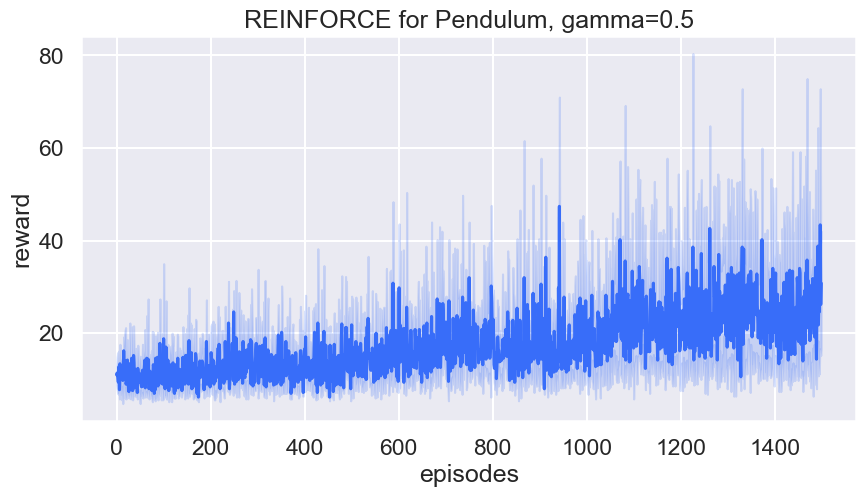

In [42]:
# save the models, images and rewards

torch.save(agent_1.net.state_dict(), "REINFORCE_gamma_0_9.pth")
torch.save(agent_2.net.state_dict(), "REINFORCE_gamma_0_7.pth")
torch.save(agent_3.net.state_dict(), "REINFORCE_gamma_0_5.pth")

df1.to_csv("REINFORCE_gamma_0_9.csv")
df2.to_csv("REINFORCE_gamma_0_7.csv")
df3.to_csv("REINFORCE_gamma_0_5.csv")

plt.figure()
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for Pendulum, gamma=0.9"
)
plt.savefig("REINFORCE_gamma_0_9.png")

plt.figure()
sns.lineplot(x="episodes", y="reward", data=df2).set(
    title="REINFORCE for Pendulum, gamma=0.7"
)
plt.savefig("REINFORCE_gamma_0_7.png")

plt.figure()
sns.lineplot(x="episodes", y="reward", data=df3).set(
    title="REINFORCE for Pendulum, gamma=0.5"
)
plt.savefig("REINFORCE_gamma_0_5.png")


In [43]:
print(rewards_over_seeds_1,"\n" ,len(rewards_over_seeds_1),"\n", len(rewards_over_seeds_1[0]))

[[array([9.], dtype=float32), array([6.], dtype=float32), array([6.], dtype=float32), array([7.], dtype=float32), array([8.], dtype=float32), array([11.], dtype=float32), array([12.], dtype=float32), array([11.], dtype=float32), array([8.], dtype=float32), array([10.], dtype=float32), array([11.], dtype=float32), array([7.], dtype=float32), array([15.], dtype=float32), array([5.], dtype=float32), array([6.], dtype=float32), array([6.], dtype=float32), array([12.], dtype=float32), array([14.], dtype=float32), array([22.], dtype=float32), array([15.], dtype=float32), array([9.], dtype=float32), array([9.], dtype=float32), array([9.], dtype=float32), array([8.], dtype=float32), array([4.], dtype=float32), array([8.], dtype=float32), array([15.], dtype=float32), array([7.], dtype=float32), array([7.], dtype=float32), array([11.], dtype=float32), array([7.], dtype=float32), array([8.], dtype=float32), array([8.], dtype=float32), array([10.], dtype=float32), array([7.], dtype=float32), array